# HPO 

for SINC sdf (series dataframe) and HOUSING db (database) 

from 29 09 Lecture 


## Theoretical Background



### Linear Regression (Analytical)


Minimizes the squared error:

$$
\min_{w} \|y - Xw\|_2^2
$$

with the closed-form solution:

$$
\hat{w} = (X^T X)^{-1} X^T y
$$

This method provides an exact solution but becomes computationally expensive for large or high-dimensional datasets.




Introduces a nonlinear mapping through kernel functions:

$$
\min_{\alpha} \|y - K\alpha\|_2^2 + \lambda\,\alpha^T K \alpha
$$

where the kernel matrix is defined as:

$$
K_{ij} = \exp(-\gamma \|x_i - x_j\|^2)
$$

and the prediction for a new sample \( x_* \) is:

$$
\hat{y}(x_*) = K(x_*, X)\,\alpha
$$



### Hyperparameter Optimization (HPO)



Optimizes α and γ through **Bayesian Optimization**, building a probabilistic surrogate of the objective (MSE) and iteratively refining the search space for best generalization.




## code implementation 

### libraries and dependencies

import libraries for data management, data visualization and usefull modules from scikit-learn 

In [2]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd

######
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict

# --- Bayesian Optimization for KernelRidge Hyperparameters --
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline


# --- bayesian oiptimization for Housing DB --- 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge  


### sinc db

we use our help code to define the toyset for this HPO task

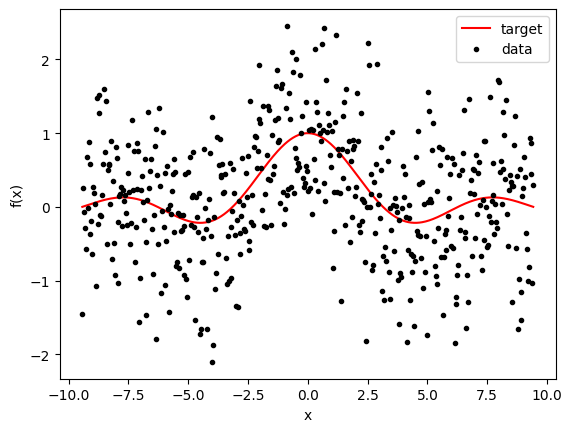

In [3]:
# using us help code:
N = 500 #número de muestras
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada
y = np.sinc(X/np.pi) #función sinc -> objetivo
var = 0.5 #varianza del ruido-> PROBAR DISTINTOS VALORES
mue = 0 #media del ruido
noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
yn = y + noise #señal co ruido
plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

now split the data

In [4]:
Xdata = X.reshape(-1,1) #N=500, P= 1
y = y.reshape(-1,1)
ydata = yn.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3)#particionar train y test

proceed to find the PARAMETERS : 

using bayesian Optimization for KernelRidge Hyperparameters we can define the pipeline


In [5]:
steps = [('reg', KernelRidge(kernel='rbf'))]
pipeline = Pipeline(steps=steps)


now, define the search space for BayesSearchCV

In [6]:


search_spaces = {
    'reg__alpha': Real(1e-6, 1e3, prior='log-uniform'),
    'reg__gamma': Real(1e-6, 1e3, prior='log-uniform')
}


and proceed using the bayesian optimization with cross-validation (10 folds and 32 iterations, that means that fit 10 folds each iteration)

In [7]:

# Bayesian optimization with cross-validation
opt = BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=32,  # Number of parameter settings that are sampled
    cv=10, # Number of folds in cross-validation
    n_jobs=4,
    scoring='neg_mean_absolute_error',
    verbose=10,
    refit=True,
    random_state=0
)


can coninute training our model 

In [8]:

opt.fit(X_train, y_train)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('reg', KernelRidge(kernel='rbf'))]),
              n_iter=32, n_jobs=4, random_state=0,
              scoring='neg_mean_absolute_error',
              search_spaces={'reg__alpha': Real(low=1e-06, high=1000.0, prior='log-uniform', transform='normalize'),
                             'reg__gamma': Real(low=1e-06, high=1000.0, prior='log-uniform', transform='normalize')},
              verbose=10)

and finding/selecting our best model: 

In [9]:
best_model = opt.best_estimator_


can print their best parameters

In [10]:

print("\n best parameters for (Bayesian Optimization):\n")
print(opt.best_params_)


 best parameters for (Bayesian Optimization):

OrderedDict([('reg__alpha', 8.928992928790393), ('reg__gamma', 0.24667641971377968)])


now, proceed predicting the output using the method predict, and plotting their result

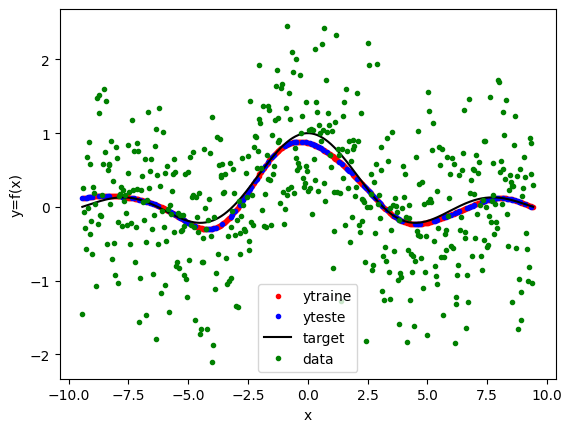

In [11]:
y_test_e = opt.best_estimator_.predict(X_test)
y_train_e = opt.best_estimator_.predict(X_train)
plt.plot(X_train,y_train_e,'r.',label='ytraine' )
plt.plot(X_test,y_test_e,'b.',label='yteste')
plt.plot(X,y,'k',label='target' )
plt.plot(Xdata,ydata,'g.',label='data' )
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

also predict on train and test sets

In [12]:

y_train_pred = opt.best_estimator_.predict(X_train)
y_test_pred = opt.best_estimator_.predict(X_test)


then, calculate the metrics, and print it : 

In [13]:

mse_train = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mse_test = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
r2_train = sklearn.metrics.r2_score(y_train, y_train_pred)
r2_test = sklearn.metrics.r2_score(y_test, y_test_pred)
print(f"MSE (train): {mse_train:.6f}")
print(f"MSE (test):  {mse_test:.6f}")
print(f"R^2 (train): {r2_train:.6f}")
print(f"R^2 (test):  {r2_test:.6f}")

MSE (train): 0.547956
MSE (test):  0.560707
R^2 (train): 0.235175
R^2 (test):  0.152836


as we see on the results and predicted output, we can inference that the HPO achieved a kernel configuration that generalizes well with balanced bias and variance. 

Also, the model captures the nonlinear sinc shape but, due to strong noise, reaches a moderate R². The near-equal MSE across splits verifies that the optimization converged to a stable and general solution.

Lets continue with the california housing DB case

####  california housing

In [14]:
housing = fetch_california_housing(as_frame=True)  # as_frame=True te da DataFrame con nombres
X = housing.data.values           # (n, d)  d=8
y = housing.target.values         # (n,)

# Split the data 
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
                

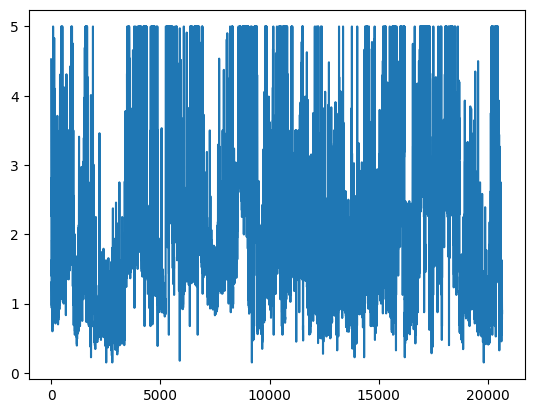

In [15]:
plt.plot(y) # print the ouput wh/ ourder
plt.show() #


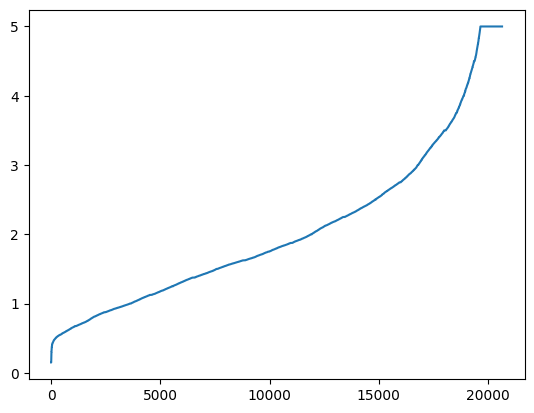

In [16]:
plt.plot(np.sort(y)) # sorting the output cause if not ...
plt.show() # this isnt lineal #

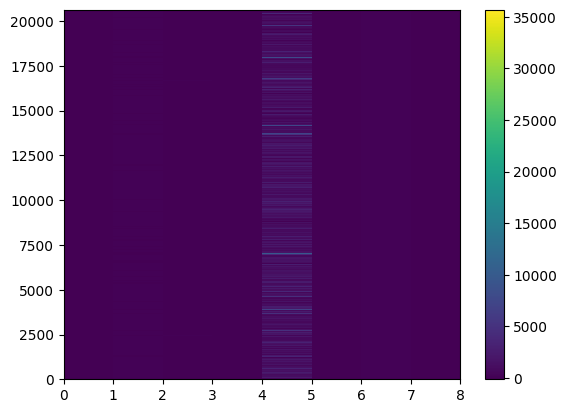

In [17]:
ind= np.argsort(y) # return index
# here we index the vector
plt.pcolormesh(X[ind]) # sorting about the index of y
plt.colorbar()
plt.show()

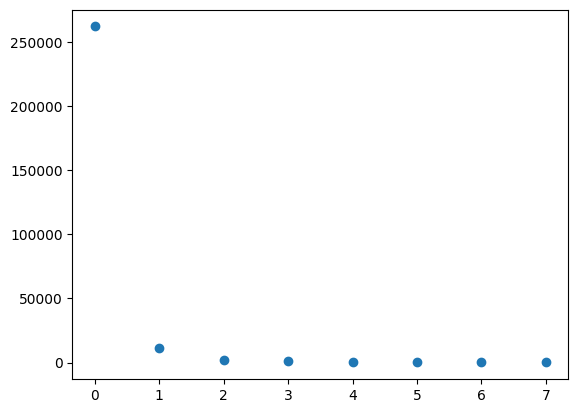

In [18]:
U,S ,Vh = np.linalg.svd(X) # S, es la descomposicion lineal en bases ortogonales (espectro de la DB)
plt.scatter(np.arange(len(S)),S)
plt.show()

### housing db 

from here:  create pipeline to polinomial model and RADIO BASIS FUNCTION (RBF) , this last one just to proof, in order to see compute process utility   

In [112]:

poly_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("reg", Ridge())
])

poly_param_grid = {
    "poly__degree": [1, 2, 10],
    "reg__alpha": [1e-3, 1e-2, 10.0]
}


define the polyonomial pipeline

In [114]:
poly_search = BayesSearchCV( # use GridSearch on this case fot compute process 
    poly_pipe, 
    poly_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs= -1,
    n_iter = 3,
    verbose= 2,
    refit=True 
)

and fit their model

In [115]:
poly_search.fit(Xtr, ytr)  # ytr is 1D from earlier cell

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('poly',
                                         PolynomialFeatures(include_bias=False)),
                                        ('reg', Ridge())]),
              n_iter=3, n_jobs=-1, scoring='neg_mean_squared_error',
              search_spaces={'poly__degree': [1, 2, 10],
                             'reg__alpha': [0.001, 0.01, 10.0]},
              verbose=2)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.70362e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Mejor grado: 10, Mejor alpha: 0.1389
MSE train (mejor): 0.6758, MSE test (mejor): 0.6928


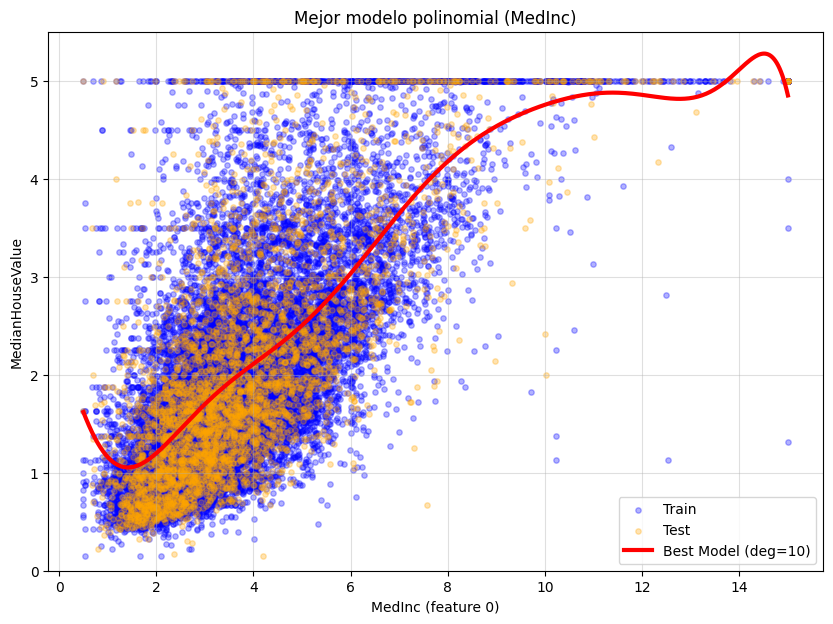


Comparativa de grados usando alpha óptimo encontrado:
Grado 1: MSE train=0.6991, MSE test=0.7091


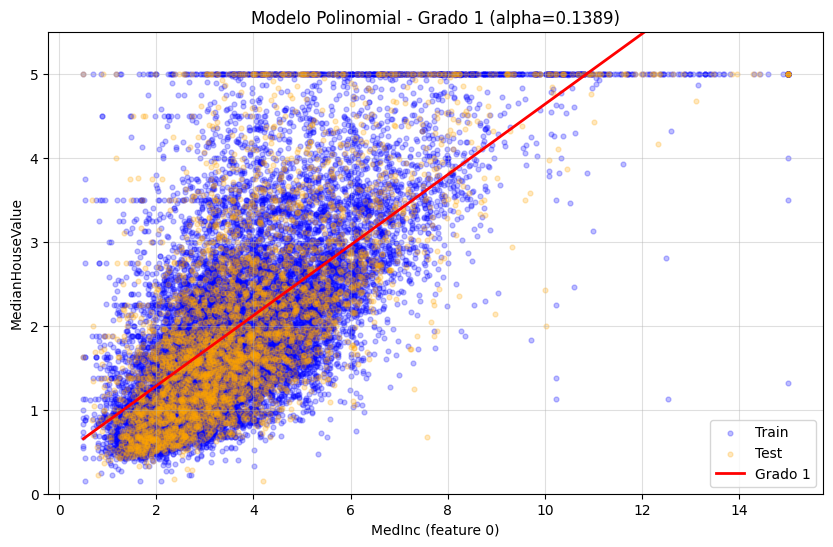

Grado 3: MSE train=0.6807, MSE test=0.6983


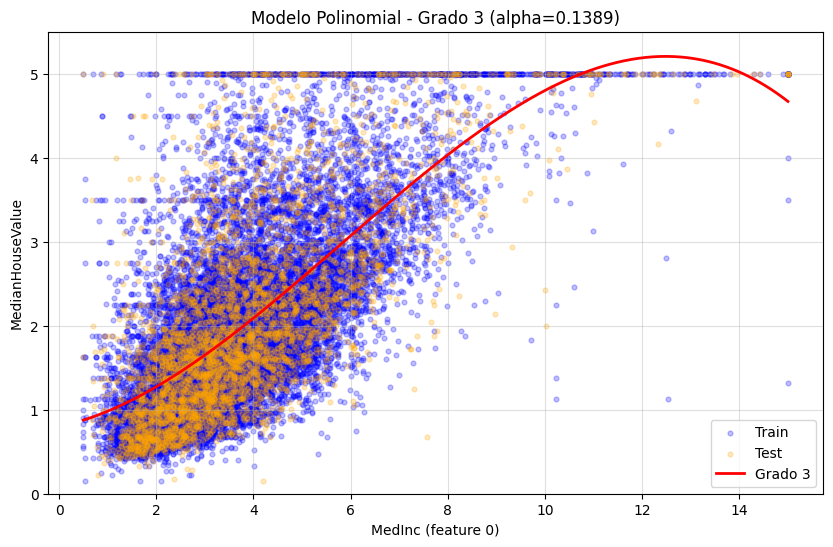

a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.70362e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Grado 10: MSE train=0.6758, MSE test=0.6928


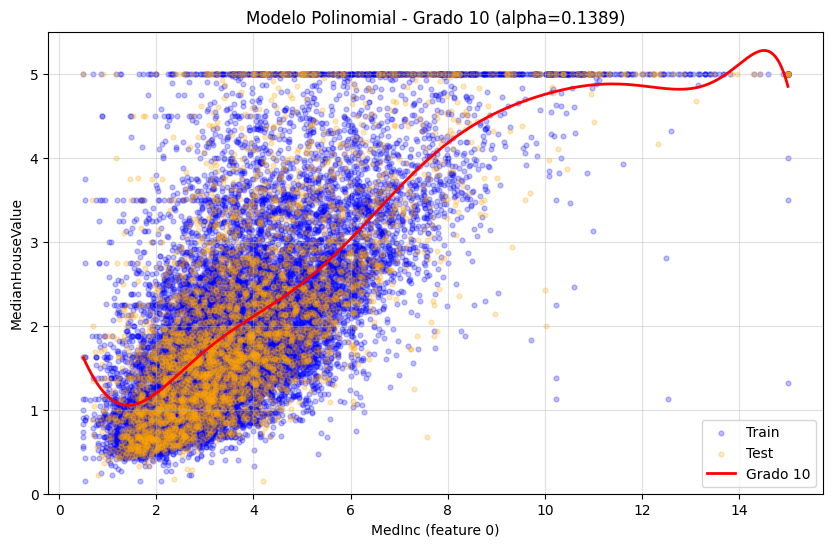

Grado 15: MSE train=0.7123, MSE test=0.7212


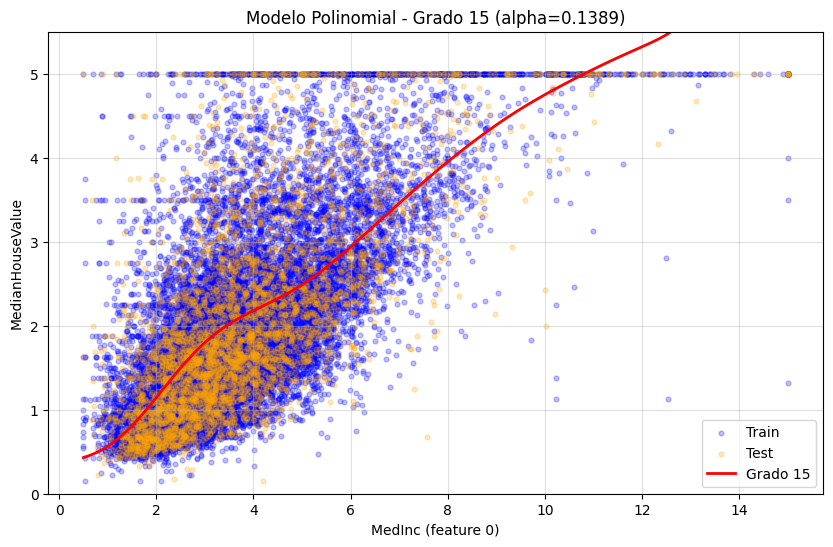

In [116]:
X_tr_med = Xtr[:, 0].reshape(-1, 1)
X_te_med = Xte[:, 0].reshape(-1, 1)

pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])

param_grid = {
    'poly__degree': np.arange(1, 11),                # grados 1..10
    'ridge__alpha': np.logspace(-3, 2, 8)            # alpha para Ridge
}

grid_search_med = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_med.fit(X_tr_med, ytr)
best_degree = grid_search_med.best_params_['poly__degree']
best_alpha = grid_search_med.best_params_['ridge__alpha']

print(f"Mejor grado: {best_degree}, Mejor alpha: {best_alpha:.4g}")

best_model_med = grid_search_med.best_estimator_

y_tr_pred = best_model_med.predict(X_tr_med)
y_te_pred = best_model_med.predict(X_te_med)
mse_tr = mean_squared_error(ytr, y_tr_pred)
mse_te = mean_squared_error(yte, y_te_pred)
print(f"MSE train (mejor): {mse_tr:.4f}, MSE test (mejor): {mse_te:.4f}")

X_range = np.linspace(X_tr_med.min(), X_tr_med.max(), 500).reshape(-1, 1)
y_range_pred = best_model_med.predict(X_range)

plt.figure(figsize=(10, 7))
plt.scatter(X_tr_med, ytr, c="blue", s=15, alpha=0.3, label="Train")
plt.scatter(X_te_med, yte, c="orange", s=15, alpha=0.3, label="Test")
plt.plot(X_range, y_range_pred, color='red', linewidth=3, label=f'Best Model (deg={best_degree})')
plt.title('Mejor modelo polinomial (MedInc)')
plt.xlabel('MedInc (feature 0)')
plt.ylabel('MedianHouseValue')
plt.ylim(0, 5.5)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

grados_a_comparar = [1, 3, int(best_degree), 15]

print("\nComparativa de grados usando alpha óptimo encontrado:")
for grado in grados_a_comparar:
    modelo = Pipeline([
        ('poly', PolynomialFeatures(degree=grado, include_bias=False)),
        ('ridge', Ridge(alpha=best_alpha))
    ])
    modelo.fit(X_tr_med, ytr)
    y_tr_g = modelo.predict(X_tr_med)
    y_te_g = modelo.predict(X_te_med)
    mse_tr_g = mean_squared_error(ytr, y_tr_g)
    mse_te_g = mean_squared_error(yte, y_te_g)

    y_range_g = modelo.predict(X_range)

    print(f"Grado {grado}: MSE train={mse_tr_g:.4f}, MSE test={mse_te_g:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(X_tr_med, ytr, c="blue", s=12, alpha=0.25, label="Train")
    plt.scatter(X_te_med, yte, c="orange", s=12, alpha=0.25, label="Test")
    plt.plot(X_range, y_range_g, color='red', linewidth=2, label=f'Grado {grado}')
    plt.title(f'Modelo Polinomial - Grado {grado} (alpha={best_alpha:.4g})')
    plt.xlabel('MedInc (feature 0)')
    plt.ylabel('MedianHouseValue')
    plt.ylim(0, 5.5)
    plt.legend()
    plt.grid(alpha=0.4)
    plt.show()

then print their best parameters found

In [118]:
print("Polynomial best params:", poly_search.best_params_)


Polynomial best params: OrderedDict([('poly__degree', 1), ('reg__alpha', 0.01)])


proceed predicting the ouitput and printing their metrics 

In [119]:

y_pred_poly_te = poly_search.predict(Xte)
y_pred_poly_tr = poly_search.predict(Xtr)

mse_poly_te = mean_squared_error(yte, y_pred_poly_te)
r2_poly_te = r2_score(yte, y_pred_poly_te)
mse_poly_tr = mean_squared_error(ytr, y_pred_poly_tr)
r2_poly_tr = r2_score(ytr, y_pred_poly_tr)

print(f"Poly MSE (train): {mse_poly_tr:.6f}, R2 (train): {r2_poly_tr:.6f}")
print(f"Poly MSE (test) : {mse_poly_te:.6f}, R2 (test) : {r2_poly_te:.6f}")

Poly MSE (train): 0.517933, R2 (train): 0.612551
Poly MSE (test) : 0.555891, R2 (test) : 0.575788


also, we can plot the prediction 

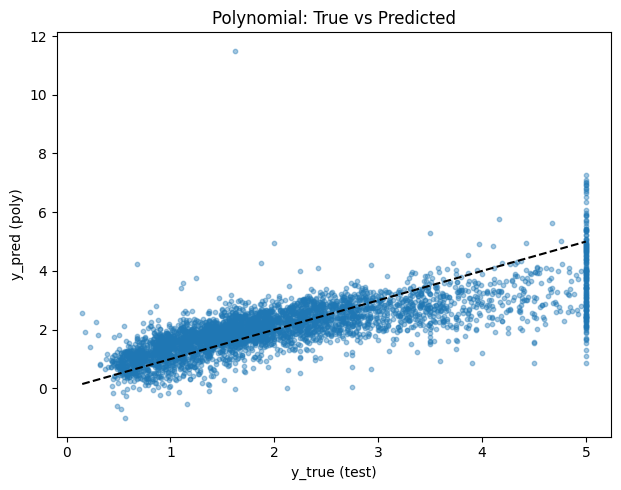

In [120]:
plt.figure(figsize=(12,5))

ymin, ymax = yte.min(), yte.max()

plt.subplot(1,2,1)
plt.scatter(yte, y_pred_poly_te, alpha=0.4, s=10)
plt.plot([ymin, ymax], [ymin, ymax], 'k--')
plt.xlabel("y_true (test)")
plt.ylabel("y_pred (poly)")
plt.title("Polynomial: True vs Predicted")

plt.tight_layout()
plt.show()

we save the best model, and then see their best parameters found

In [121]:
best_model = poly_search.best_estimator_

In [88]:

print("\n best parameters for (Bayesian Optimization):\n")
print(poly_search.best_params_)


 best parameters for (Bayesian Optimization):

{'poly__degree': 1, 'reg__alpha': 0.001}


 Finally, proceed with a RBF KernelRidge pipeline: Bayesian optimization (proof of concept just for computting process) 


In [122]:
rbf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", KernelRidge(kernel='rbf'))
])

rbf_search_spaces = {
    'reg__alpha': Real(1e-6, 1e3, prior='log-uniform'),
    'reg__gamma': Real(1e-6, 1e3, prior='log-uniform')
}

rbf_opt = BayesSearchCV( # we use the BayesSaerch CV
    rbf_pipe,
    rbf_search_spaces,
    n_iter=3,
    cv=5,
    n_jobs=1, # put on 1 to avoid parallel copies of the kernel matrix 
    scoring='neg_mean_squared_error',
    verbose=0,
    refit=True,
    random_state=0
)


In [ ]:
rbf_opt.fit(Xtr, ytr)


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('reg', KernelRidge(kernel='rbf'))]),
              n_iter=3, random_state=0, scoring='neg_mean_squared_error',
              search_spaces={'reg__alpha': Real(low=1e-06, high=1000.0, prior='log-uniform', transform='normalize'),
                             'reg__gamma': Real(low=1e-06, high=1000.0, prior='log-uniform', transform='normalize')})

if we  note, the RBF takes longer than the Polynomial method

now, print the best kernel rigde parametrs

In [ ]:
print("RBF KernelRidge best params:", rbf_opt.best_params_)

RBF KernelRidge best params: OrderedDict([('reg__alpha', 0.06007274600371167), ('reg__gamma', 1.2153897793615955)])


and predcit on the train and test data set

In [ ]:

y_pred_rbf_te = rbf_opt.predict(Xte)
y_pred_rbf_tr = rbf_opt.predict(Xtr)


proceed computing the metrics

In [ ]:

mse_rbf_te = mean_squared_error(yte, y_pred_rbf_te)
r2_rbf_te = r2_score(yte, y_pred_rbf_te)
mse_rbf_tr = mean_squared_error(ytr, y_pred_rbf_tr)
r2_rbf_tr = r2_score(ytr, y_pred_rbf_tr)

print(f"RBF MSE (train): {mse_rbf_tr:.6f}, R2 (train): {r2_rbf_tr:.6f}")
print(f"RBF MSE (test) : {mse_rbf_te:.6f}, R2 (test) : {r2_rbf_te:.6f}")


RBF MSE (train): 0.134482, R2 (train): 0.899398
RBF MSE (test) : 0.361808, R2 (test) : 0.723897


also do a qucick comparison 

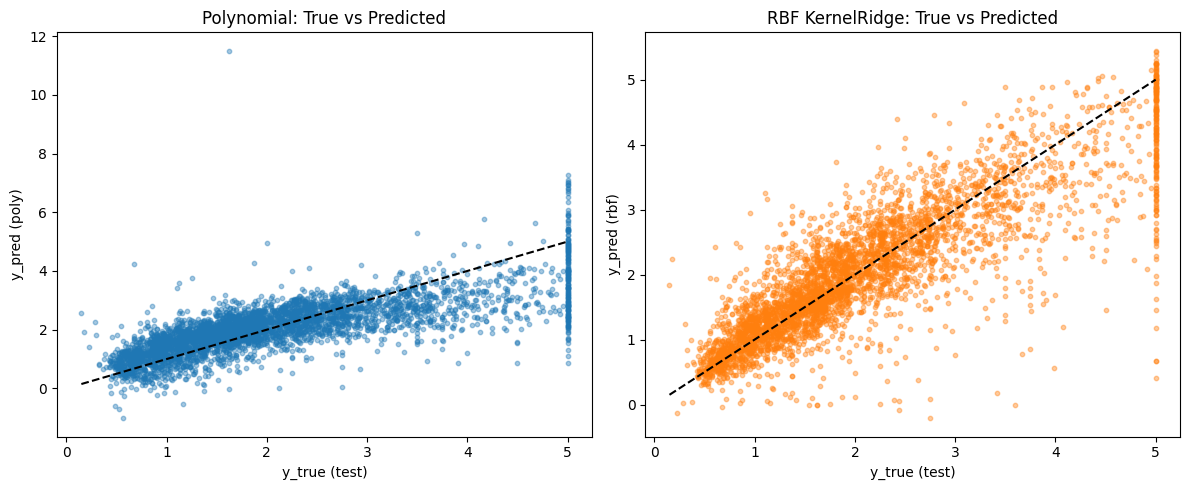

In [ ]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(yte, y_pred_poly_te, alpha=0.4, s=10)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'k--')
plt.xlabel("y_true (test)")
plt.ylabel("y_pred (poly)")
plt.title("Polynomial: True vs Predicted")

plt.subplot(1,2,2)
plt.scatter(yte, y_pred_rbf_te, alpha=0.4, s=10, color='tab:orange')
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'k--')
plt.xlabel("y_true (test)")
plt.ylabel("y_pred (rbf)")
plt.title("RBF KernelRidge: True vs Predicted")

plt.tight_layout()
plt.show()

### Quick proof 

lets compare this three models on a rial case 

first, gonna select a real test sample, plot its features, and predict with the trained models


In [ ]:
case_idx = 0  # change to try other test samples
x_case = Xte[case_idx].reshape(1, -1)
true_price = yte[case_idx]

we can feature names from the fetched dataset (housing was loaded as_frame=True)


In [ ]:


feature_names = housing.feature_names if hasattr(housing, "feature_names") else [f"f{i}" for i in range(x_case.shape[1])]


also we can plot the feature vector for the selected house


In [ ]:

plt.figure(figsize=(10,4))
plt.bar(feature_names, x_case.ravel(), color='tab:blue')
plt.xticks(rotation=45, ha='right')
plt.title(f"Feature vector for test sample index {case_idx}")
plt.ylabel("feature value")
plt.tight_layout()
plt.show()

then, predict with the polynomial pipeline and the RBF KernelRidge

In [ ]:

pred_poly = poly_search.predict(x_case)
pred_rbf = rbf_opt.predict(x_case)


we can print the numeric results

In [ ]:
print(f"True median house value: {true_price:.3f}")
print(f"Polynomial model prediction: {pred_poly.item():.3f}")
print(f"RBF KernelRidge prediction:  {pred_rbf.item():.3f}")


True median house value: 0.477
Polynomial model prediction: 0.719
RBF KernelRidge prediction:  0.418


finally, show a small comparison plot

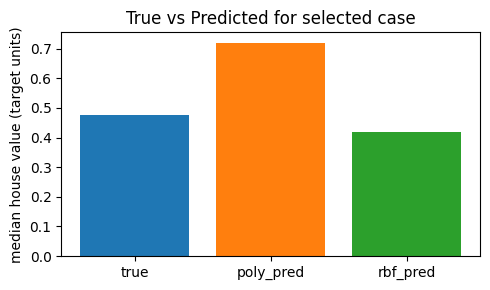

In [ ]:
plt.figure(figsize=(5,3))
labels = ['true', 'poly_pred', 'rbf_pred']
vals = [true_price, pred_poly.item(), pred_rbf.item()]
plt.bar(labels, vals, color=['C0','C1','C2'])
plt.ylabel("median house value (target units)")
plt.title("True vs Predicted for selected case")
plt.tight_layout()
plt.show()

## conclusions

as we can see, 
- the polynomial model slightly overestimates the true median value, while the RBF kernel ridge gives a smoother, more regularized prediction closer to the true target — indicating better generalization but lower variance fit.

also, 
- The Bayesian HPO efficiently selected optimal α and γ for the RBF Kernel Ridge, balancing bias and variance without overfitting, but the Kernel Ridge (RBF) generalized better across train/test than the polynomial model, offering smoother predictions in both the sinc and housing datasets, and the polynomial regression captured high-variance local trends but exaggerated amplitudes, showing slight overfitting in noisy regions.